In [ ]:
import mpmath
from mpmath import mp, gamma, im, pi, log, mpf, exp, power, log10

mp.dps = 100

import math
import numpy as np
from matplotlib import pyplot as plt

In [29]:
import numpy as np

# Global random generator
rng = np.random.default_rng()

def get_exp_sketch(m: int, lam: float) -> np.ndarray:
    """
    Generate m i.i.d. exponential random variables with rate lam
    (scale = 1/lam) using the global numpy.random.Generator.
    """
    return rng.exponential(scale=1/lam, size=m)

def estimate_exp_sketch(expsketch: np.ndarray) -> float:
    return (len(expsketch)-1)/expsketch.sum()

def quantize(k: float, expsketch: np.ndarray) -> np.ndarray:
    """
    For each value x in expsketch, return floor(-log_k(x)).
    """
    return np.floor(-np.log(expsketch) / np.log(k)).astype(int)

def estimate_log_exp_sketch_2(k: float, logexpsketch: np.ndarray) -> float:
    """
    Method 2 estimator:
    Returns (m - 1) / sum_i [k^(-r_i - c_k)], with the same c_k as above.
    """
    m = logexpsketch.size
    c_k = (np.log(k - 1) + np.log(np.log(np.e) / np.log(k))) / np.log(k)
    return (m - 1) / np.sum(k ** (-logexpsketch - c_k))

def how_many_bits_for_the_register(k, limit_of_solvability: float):
    # i want k^r_max <= limit_of_solvability
    # i want r_max = maximum_number written on b bits
    # the largest magnitude we need to encode:
    r_bound = math.log(limit_of_solvability) / math.log(k)
    # bits to encode 0..⌈r_bound⌉:
    bits_mag = math.ceil(math.log2(r_bound + 1))
    # plus one bit for sign
    return bits_mag + 1

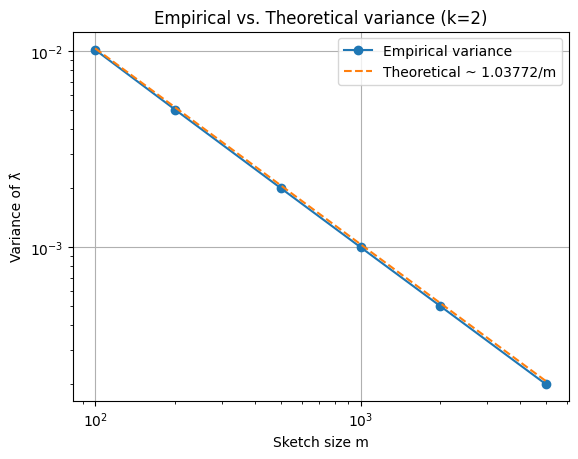

In [33]:
import numpy as np
import matplotlib.pyplot as plt



def simulate_variance(k, lam, ms, n_trials):
    variances = []
    for m in ms:
        estimates = []
        for _ in range(n_trials):
            sketch = get_exp_sketch(m, lam)
            log_sketch = quantize(k, sketch)
            estimates.append(estimate_log_exp_sketch_2(k, log_sketch))
        variances.append(np.var(estimates, ddof=1))
    return np.array(variances)

def simulate_variance_expsketch(k, lam, ms, n_trials):
    variances = []
    for m in ms:
        estimates = []
        for _ in range(n_trials):
            sketch = get_exp_sketch(m, lam)
            estimates.append(estimate_exp_sketch(sketch))
        variances.append(np.var(estimates, ddof=1))
    return np.array(variances)

# Parameters
k = 2.0
lam = 1.0
ms = np.array([100, 200, 500, 1000, 2000, 5000])
n_trials = 1000000

# Empirical variances
vars_empirical = simulate_variance_expsketch(k, lam, ms, n_trials)

# Fit log-log linear regression to estimate c_k
log_ms = np.log(ms)
log_vars = np.log(vars_empirical)
slope, intercept = np.polyfit(log_ms, log_vars, 1)
c_hat = np.exp(intercept)

# Theoretical variance ~ c_hat / m
vars_theoretical = c_hat / ms

# Plot empirical vs. theoretical
plt.figure()
plt.loglog(ms, vars_empirical, marker='o', label='Empirical variance')
plt.loglog(ms, vars_theoretical, linestyle='--', label=f'Theoretical ~ {c_hat:.5f}/m')
plt.xlabel('Sketch size m')
plt.ylabel('Variance of λ̂')
plt.title('Empirical vs. Theoretical variance (k=2)')
plt.grid(True)
plt.legend()
plt.show()


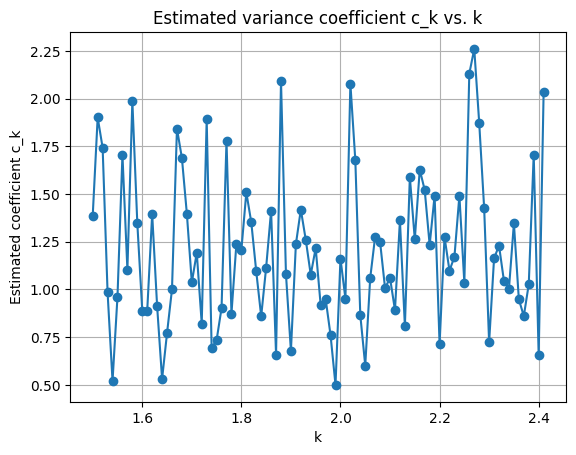

In [34]:
# Simulation parameters
lam = 1.0
ms = np.array([100, 200, 500, 1000, 2000, 5000])
n_trials = 100  # reduce for speed; increase for smoother estimates

# Range of k values
k_values = np.arange(1.5, 2.41, 0.01)
c_hats = []

# Compute coefficient c_k for each k by fitting Var ~ c_k/m
for k in k_values:
    vars_emp = simulate_variance(k, lam, ms, n_trials)
    slope, intercept = np.polyfit(np.log(ms), np.log(vars_emp), 1)
    c_hats.append(np.exp(intercept))

c_hats = np.array(c_hats)

# Plot c_k vs. k on linear axes
plt.figure()
plt.plot(k_values, c_hats, marker='o')
plt.xlabel('k')
plt.ylabel('Estimated coefficient c_k')
plt.title('Estimated variance coefficient c_k vs. k')
plt.grid(True)

In [14]:
import numpy as np

def simulate_variance_coeff(k, lam, ms, n_trials):
    """
    For each m in ms:
      1) draw n_trials independent estimates of lambda via your sketch
      2) compute the sample variance of those estimates
    Then regress log Var against log m and return exp(intercept) = your c_k.
    """
    vars_emp = []
    # for each register size m
    for m in ms:
        # run n_trials experiments
        est = np.empty(n_trials)
        for i in range(n_trials):
            exps = get_exp_sketch(m, lam)
            r    = quantize(k, exps)
            est[i] = estimate_log_exp_sketch_2(k, r)
        # unbiased sample variance
        vars_emp.append(np.var(est, ddof=1))

    # fit log Var = slope·log m + intercept
    slope, intercept = np.polyfit(np.log(ms), np.log(vars_emp), 1)
    return np.exp(intercept)

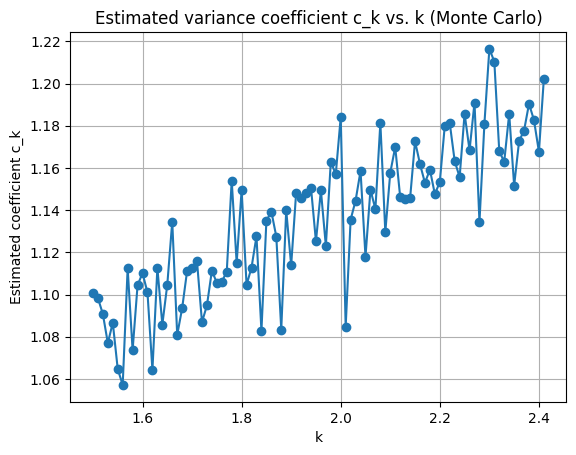

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Re-define core functions
rng = np.random.default_rng()


# Simulation parameters
lam = 1.0
ms = np.array([100, 250, 500, 1000])
n_trials = 100000  # increase for smoother estimates

# Range of k values
k_values = np.arange(1.5, 2.41, 0.01)
c_hats = [simulate_variance_coeff(k, lam, ms, n_trials) for k in k_values]

# Plot c_k vs. k on linear axes
plt.figure()
plt.plot(k_values, c_hats, marker='o')
plt.xlabel('k')
plt.ylabel('Estimated coefficient c_k')
plt.title('Estimated variance coefficient c_k vs. k (Monte Carlo)')
plt.grid(True)
plt.show()


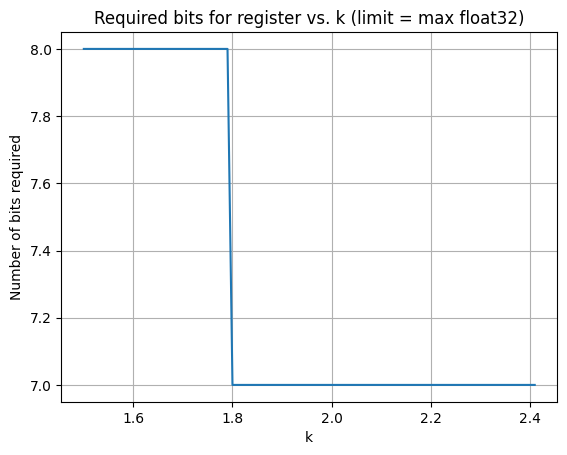

In [23]:
import math
# Maximum representable float32
limit_of_solvability = np.finfo(np.float32).max
limit_of_solvability = 10**16

# Range of k values
k_values = np.arange(1.5, 2.41, 0.01)
bits_required = [how_many_bits_for_the_register(k, limit_of_solvability) for k in k_values]

# Plot
plt.figure()
plt.plot(k_values, bits_required)
plt.xlabel('k')
plt.ylabel('Number of bits required')
plt.title('Required bits for register vs. k (limit = max float32)')
plt.grid(True)
plt.show()

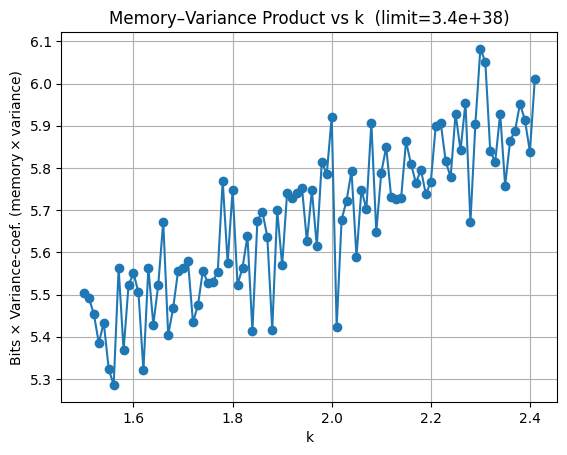

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt

def how_many_bits_for_the_register(k, limit_of_solvability: float):
    r_bound = math.log(limit_of_solvability) / math.log(k)
    bits_mag = math.ceil(math.log2(r_bound + 1))
    return bits_mag + 1  # +1 for the sign bit

k_values = np.arange(1.5, 2.41, 0.01)

c_hats2 = np.array(c_hats)   # <-- fill in your array of length len(k_values)

# 3) Choose your numeric limit (e.g. np.finfo(np.float32).max)
limit_of_solvability = np.finfo(np.float32).max

# 4) Compute bits and the memory‐variance product
bits_required = np.array([how_many_bits_for_the_register(k, limit_of_solvability)
                          for k in k_values])

bits_required = np.array([5 for k in k_values])
mvp = bits_required * c_hats

# 5) Plot
plt.figure()
plt.plot(k_values, mvp, marker='o')
plt.xlabel('k')
plt.ylabel('Bits × Variance-coef. (memory × variance)')
plt.title(f'Memory–Variance Product vs k  (limit={limit_of_solvability:.1e})')
plt.grid(True)
plt.show()